# Text Summarization Project

<u>Notes</u>
* Dataset: https://huggingface.co/datasets/har1/MTS_Dialogue-Clinical_Note
* Fine-tuning model: bart-base
* NLI model: https://huggingface.co/FacebookAI/roberta-large-mnli
* Teacher forcing is automatically applied during training
* During inference, you should consider beam search and temperature

<u>Action Items</u>

* <s>Apply a fine-tuned text summarization model to the dataset and see what comes out (done)</s>
* <s>Apply bart-base to the dataset and see what comes out (done)</s>
* <s>Preprocessing - do you want to skip any samples? Also, I don't think they flagged training vs. validation, so you may want to do the splits yourself. Do you want to ignore classes with low representation?</s>
* You should understand the APIs for common huggingface classes (Trainer, TrainingArguments) - this is mostly done
* Seq2SeqTrainingArguments
    * generation max len = 500 (349 is max output seq len in dataset)
    * generation num beams = 4 (seems like everyone's default)
    * do_sample - False to start?
    * temperature, top_k - read about this
    * earlystopping = True - how do I pass this?
    * **custom generation config?**
* Start with training and inferring on the same samples as a sanity check (already did for 1 sample). Then gradually increase the number of samples and adjust hyperparameters as needed.
* In huggingface, teacher forcing is applied 100% of the time by default (confirm this in the documentation)
* **Mixed precision or lower precision training for efficiency**
* You should understand how BART is pretrained. You should understand the "checkpoint" you are loading with bart-base. You should understand BART-base and BART-large.
    * **Should you unfreeze the final dense layer of the decoder? Well, on 1 sample, with LoRA, you were able to get perfect performance**
* <s>Understand LoRA arguments</s>
* **BERTScore IDF dict**
* Are there any good regularization or generalization techniques?
    * Label smoothing?
    * Data augmentation? - use SOTA LLM to enrich the dataset
    * Dropout, weight decay (L1/L2)
    * Early stopping
* <s>Is evaluation really slow with valmet? I think it was, but can you confirm? Yes - interestingly, it's very slow even if I use only BERT or only ROUGE</s>
* Testing
    * <s>har1 did not convert the test set labels to the new format, so there's no test set. I don't think it's feasible to manually do this myself - there are 400 test samples.</s>
    * <s>I ran predictions on 10 samples from training dataset and 10 samples from validation dataset. I'm on the right track, but I think performance is not as good as har1.</s>
    * <s>Resplit into train/val/test</s>
    * As a last step, you could try running on the actual test data without labels and do some manual checking
* Check the "MEDIQA" challenges
    * Task A is both summarization and classification - you're supposed to predict the section header as well. You can still do this I think. Use the encoder output.
    * I think I should do just summarization first.
* You got access to PhysioNet

<u>Hyperparameter tuning</u>
* Unfreezing the lm_head is definitely needed; the model cannot learn this domain-specific knowledge with LoRA alone.
    * You could try applying LoRA to lm_head.
    * For educational purposes, try disabling LoRA and unfreezing the lm_head.
    * With this change, the model is now overfitting. You will need to add regularization to lm_head.
* **Right now, I think the order should be learning rate, grad accum, lr scheduler. Then LoRA rank, alpha**
* If I increase grad accum, then I'm basically taking bigger steps. Does this help? No, convergence and steady-state are worst.
* If I decrease grad accum, then I'm taking smaller steps. Does this help?
* Learning rate, lr scheduler, warmup, AdamW params?, batch size, grad accum
* LoRA - rank, alpha, dropout
* Mixed/lower precision training
* model.generate() - eval and predict only
* Try a larger model. Try unfreezing the dense layer.

<u>Ayman's Suggestions</u>
* Compare other small models like flan-t5, gpt-2
* Try packing the samples for efficiency - this is taking too long to figure out. You will probably need to use SFTTrainer. Figure this out later.
    * DataCollatorWithFlattening: https://research.ibm.com/blog/hugging-face-training-flash-attention
    * SFTTrainer
* <s>push_to_hub saves the final model state, I think (including if you load best model). Check out wandb.</s>
* <s>unsloth - quantization, fine-tuning, pruning</s>

<u>Questions</u>

* How useful is ROUGE? Oftentimes people report ROUGE as their validation metric, but it never seems to change much over epochs. And it's usually kind of low.
* **model.generate() and whether I should use it for evaluation**

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# !pip install transformers
# !pip install datasets
# !pip install evaluate
# !pip install peft
# !pip install bert-score
# !pip install rouge-score

In [2]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, AutoConfig, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, EarlyStoppingCallback, GenerationConfig, TrainerCallback, BartForConditionalGeneration, BartConfig
# from trl import SFTTrainer
from datasets import load_dataset
from peft import LoraConfig, TaskType, get_peft_model
import evaluate
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import math
import matplotlib.pyplot as plt
import re
import gc

In [ ]:
# torch.cuda.is_available = lambda : False
# torch.cuda.is_available()

# Get dataset and tokenize

In [4]:
model_name = 'facebook/bart-base'
# model_name = 'facebook/bart-large-cnn'

tokenizer = AutoTokenizer.from_pretrained(model_name, truncation_side='left') # the beginning of the dialogue usually contains less information (hi, how are you?) so truncate from the left
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

C:\ProgramData\anaconda3\envs\env_dl_cv_transformer_sentpiece\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# print(f'pad_token_id: {tokenizer.pad_token_id}')
# print(f'bos_token_id: {tokenizer.bos_token_id}')
# print(f'eos_token_id: {tokenizer.eos_token_id}')
# dir(tokenizer)

In [5]:
ds = load_dataset('ryanwtsai/MTS_Dialogue-Clinical_Note_TrainValTestSplit', streaming=False)
ds

DatasetDict({
    train: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 1040
    })
    val: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 132
    })
    test: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 128
    })
})

In [ ]:
# Subset if desired

# ds['train'] = ds['train'].shuffle(seed=42).select(range(100))
# ds['train'] = ds['train'].select(range(109,ds['train'].num_rows))
# ds['val'] = ds['train'].shuffle(seed=42).select(range(12))
# ds

In [6]:
# Class to handle tokenization and dataloading

class TextPreprocessor:
    def __init__(self, tokenizer, model, dataset, input_col, output_col=None, padding=False, truncation=True, batch_size=8):
        """
        Initialize the class with a tokenizer, model, dataset, and various tokenization options.
        - dataset - currently assumes this is a dataset dictionary with keys 'train', 'val', 'test'
        - input_col: The column name for the input sequences.
        - output_col: The column name for the output sequences (if applicable). If None, assume single sequence input.
        - padding: Padding strategy (e.g., "max_length", "longest", or a specific integer length).
        - truncation: Truncation strategy (boolean or "longest_first").
        """
        self.tokenizer = tokenizer
        # self.model = model
        self.model_max_length = model.config.max_position_embeddings
        self.dataset = dataset
        self.input_col = input_col
        self.output_col = output_col
        self.padding = padding
        self.truncation = truncation
        self.batch_size = batch_size
        self.tokenized_dataset = {}
        self.truncation_tracker = {}
        self.dataloader = {}

    def tokenize_function(self, examples):
        # Tokenize a pair of sequences (input-output pair, e.g. for summarization)
        if self.output_col:
            tokenized = self.tokenizer(
                examples[self.input_col],
                text_target=examples[self.output_col],   # target sequence
                padding=self.padding,
                truncation=self.truncation,
                max_length=self.model_max_length,
                return_tensors='np',
                return_length=True,
                # return_overflowing_tokens=True
            )

        # Tokenize a single sequence
        else:
            tokenized = self.tokenizer(
                examples[self.input_col],
                padding=self.padding,
                truncation=self.truncation,
                max_length=self.model_max_length,
                return_tensors='np',
                return_length=True,
                # return_overflowing_tokens=True
            )

        # tokenized = dictionary
        # keys = input_ids, attention_mask, labels
        # size = batch size, sequence length (input_ids and attention_mask have the same length)

        # Check for truncation
        if self.truncation not in [False, 'do_not_truncate']:
            # Get non-truncated lengths
            input_lens = self.tokenizer(examples[self.input_col], truncation=False, return_tensors='np', return_length=True)['length']
            # print(type(input_lens))
            # print(input_lens.shape)
            # print(input_lens[:10])

            # Calculate how many tokens were truncated
            trunc_lens = np.clip(input_lens - tokenized['length'], a_min=0, a_max=None)
            trunc_lens_indexing = np.nonzero(trunc_lens > 0)[0]
            # print(type(trunc_lens))
            # print(trunc_lens.shape)
            # print(trunc_lens_indexing[:10])

            # Get IDs for non-zero truncations
            # print(type(examples['ID']))
            # trunc_ids = examples['ID'][trunc_lens_indexing]
            trunc_ids = [examples['ID'][i] for i in trunc_lens_indexing]
            trunc_lens = trunc_lens[trunc_lens > 0].tolist()

            self.truncation_tracker.update(dict(zip(trunc_ids, trunc_lens)))

        return tokenized

    def tokenize_dataset(self):
        """Applies tokenization to the dataset using the tokenize_function."""

        self.tokenized_dataset = self.dataset.map(self.tokenize_function, batched=True)
        # self.tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

        # for key in self.dataset:
        #     print(f'Tokenizing {key} split...')
        #     self.tokenized_dataset[key] = self.dataset[key].map(self.tokenize_function, batched=True)
        #     self.tokenized_dataset[key].set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    # def create_dataloader(self, shuffle_train=True):
    #     """Creates a DataLoader from the tokenized dataset."""
    #     if self.tokenized_dataset == {}:
    #         raise ValueError("Tokenized dataset is not available. Run tokenize_dataset() first.")

    #     # Convert to PyTorch DataLoader for batching
    #     for key in self.tokenized_dataset:
    #         shuffle = shuffle_train if key == 'train' else False
    #         print(f'Creating {key} dataloader...')
    #         self.dataloader[key] = DataLoader(self.tokenized_dataset[key], batch_size=self.batch_size, shuffle=shuffle)

    # def get_dataloader(self):
    #     """Returns the DataLoader, creating it if necessary."""
    #     if self.dataloader == {}:
    #         self.create_dataloader()
    #     return self.dataloader

In [7]:
preprocessor = TextPreprocessor(tokenizer, model, ds, 'dialogue', output_col='section_text')

preprocessor.tokenize_dataset()

Map:   0%|          | 0/132 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

In [8]:
preprocessor.truncation_tracker
del model
gc.collect()

217

# Define validation metrics

In [ ]:
bertscore = evaluate.load('bertscore')
rouge = evaluate.load('rouge')
print(bertscore.__class__.__name__)
print(rouge.__class__.__name__)

In [ ]:
class ValidationMetrics:
    def __init__(self, tokenizer, *metrics):
        self.tokenizer = tokenizer
        self.metrics = metrics

    def compute_metrics(self, evalpred):
        predictions = np.copy(evalpred.predictions)
        labels = np.copy(evalpred.label_ids)
        # print(f'Unique predictions: {sorted(set(predictions.flatten()))}')
        # print(f'Unique labels: {sorted(set(labels.flatten()))}')

        # Replace -100 (padding used to ignore token in loss computation) with pad_token_id
        # Otherwise tokenizer.batch_decode throws an error
        predictions[predictions == -100] = self.tokenizer.pad_token_id
        labels[labels == -100] = self.tokenizer.pad_token_id
        # print(f'Unique predictions (after): {sorted(set(predictions.flatten()))}')
        # print(f'Unique labels (after): {sorted(set(labels.flatten()))}')

        decoded_preds = self.tokenizer.batch_decode(predictions, skip_special_tokens=True)
        decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

        results = {}
        for metric in self.metrics:
            if metric.__class__.__name__ == "BERTScore":
                result = metric.compute(predictions=decoded_preds, references=decoded_labels, model_type='distilbert-base-uncased')
                result.pop('hashcode')
                result = {f'eval_bert_{k}': np.mean(np.array(v)) for k, v in result.items()}
            elif metric.__class__.__name__ == "Rouge":
                result = metric.compute(predictions=decoded_preds, references=decoded_labels)
                results = {f'eval_{k}': v for k, v in results.items()}

            results.update(result)

        return results

valmet = ValidationMetrics(tokenizer, bertscore, rouge)

# Training

In [155]:
# Training hyperparameters

num_epochs = 10
learning_rate = 1.6e-3
logname = './logs/070_bart-base.txt'
savemodel = './output/070/'

train_batch_size = 2
eval_batch_size = 2
grad_accum = 4

# LoRA
r = 8
lora_alpha = 32
lora_dropout = 0

# BART
dropout = 0.1 # applied after linear transformation in ffnn in encoder/decoder. default = 0.1.
attention_dropout = 0.1 # attention layers in encoder/decoder. default = 0.1.
activation_dropout = 0.1 # applied after activations in ffnn in encoder/decoder. default = 0.1.

# Regularization
weight_decay = 10 # default = 0

In [156]:
peft_config = LoraConfig(task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout)
model_config = AutoConfig.from_pretrained(model_name, 
                                    dropout=dropout,
                                    attention_dropout=attention_dropout,
                                    activation_dropout=activation_dropout)

class ModelInitializer():
    def __init__(self, model_name, model_cfg=None, peft_cfg=None):
        self.model_name = model_name
        self.model_cfg = model_cfg
        self.peft_cfg = peft_cfg
    
    def model_init(self):
        # Get base model
        if self.model_cfg is not None:
            model = AutoModelForSeq2SeqLM.from_pretrained(self.model_name, config=self.model_cfg)
        else:
            model = AutoModelForSeq2SeqLM.from_pretrained(self.model_name)

        # Apply PEFT
        if self.peft_cfg is not None:
            model = get_peft_model(model, self.peft_cfg)
        
        for name, module in model.named_modules(): # unfreeze lm_head
            if "lm_head" in name:
                print(f"Unfreezing {name}")
                module.weight.requires_grad = True

        # print("Full list of unfrozen weights:")
        # for name, module in model.named_modules():
        #     if hasattr(module, "weight") and module.weight.requires_grad:
        #         print(name)
        
        model.print_trainable_parameters()
        return model   

modelinit = ModelInitializer(model_name, model_cfg=model_config, peft_cfg=peft_config)

In [ ]:
# model = modelinit.model_init()
# model.config

In [ ]:
# model.base_model.model.model.shared
# model.base_model.model.model.encoder.embed_tokens
# model.base_model.model.model.decoder.embed_tokens

In [ ]:
# for name, module in model.named_modules():
#     if hasattr(module, "weight") and module.weight.requires_grad:
#         print(name)
# del model

In [157]:
output_dir = './output/'
logging_dir = './logs/'

ds_train = preprocessor.tokenized_dataset['train']
ds_eval = preprocessor.tokenized_dataset['val']

# To debug samples
# class PrintIDCallback(TrainerCallback):
#     def on_train_batch_start(self, args, state, control, **kwargs):
#         # Extract the batch's ID from the input data
#         if 'inputs' in kwargs:
#             inputs = kwargs['inputs']  # The inputs from the trainer
#             ids = [feature['ID'] for feature in inputs]
#             print(f"Processing IDs: {ids}", flush=True)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=modelinit.model_init())

training_args = Seq2SeqTrainingArguments(
    disable_tqdm=True,  # disable progress bar
    output_dir=output_dir,
    save_strategy='no',
    # save_strategy='epoch', # save model checkpoints at the end of each epoch
    # save_strategy='steps',
    # save_steps=0.1,
    # save_total_limit=2, # only save the last N checkpoints
    # eval_strategy='epoch',  # run validation at the end of each epoch
    # eval_strategy='no',
    eval_strategy='steps',
    eval_steps=math.ceil(num_epochs*ds_train.num_rows/(grad_accum*train_batch_size)/10),

    # load_best_model_at_end=True,  # load the best model found during training
    # metric_for_best_model="eval_loss",  # Metric to monitor for the best model
    # metric_for_best_model='accuracy', # this needs to match a key in the returned dictionary from compute_metrics()
    # greater_is_better=True, # higher value for metric_for_best_model is better

    # Logs report training and validation metrics, which may be visualized (including in real time) using TensorBoard.
    logging_dir=logging_dir,
    # logging_strategy='no',
    # logging_strategy='epoch',
    logging_strategy='steps',
    # logging_steps=num_epochs/100,
    logging_steps=math.ceil(num_epochs*ds_train.num_rows/(grad_accum*train_batch_size)/100),

    per_device_train_batch_size=train_batch_size, # batch size per device (CPU core/GPU/etc.)
    per_device_eval_batch_size=eval_batch_size, # batch size per device (CPU core/GPU/etc.)

    # Training hyperparameters
    num_train_epochs=num_epochs, # max epochs
    gradient_accumulation_steps=grad_accum,
    # learning_rate=5e-8, # default is 5e-5
    # learning_rate=3e-5, # FYI: the default linear scheduler updates learning rate per batch
    learning_rate=learning_rate,
    # warmup_ratio=0.2, # 20% of training steps
    # max_grad_norm=1.0,
    weight_decay=weight_decay,

    # Seq2Seq
    predict_with_generate=True,
    generation_max_length=500,
    #generation_num_beams=4,
    #generation_config=??, Can this set early_stopping and other options?

    # Random
    seed=42,
)

trainer = Seq2SeqTrainer(
    # model=model,
    model_init=modelinit.model_init,
    args=training_args,
    # train_dataset=tokenized_datasets['train'],
    # eval_dataset=tokenized_datasets['test'],  # This is the validation dataset
    train_dataset=ds_train,
    eval_dataset=ds_eval,
    tokenizer=tokenizer, # only used for generative tasks like translation, summarization, question-answering (to convert decoder predictions/logits back to words) or to work with metrics that require post-processing (BLEU, ROUGE)
    data_collator=data_collator, # dynamic padding
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop after 3 epochs without improvement
    # compute_metrics=valmet.compute_metrics,
)

Unfreezing base_model.model.lm_head
trainable params: 39,045,888 || all params: 139,862,784 || trainable%: 27.9173
Unfreezing base_model.model.lm_head
trainable params: 39,045,888 || all params: 139,862,784 || trainable%: 27.9173


In [158]:
print(trainer.model.peft_config['default'])
print('')
print(f"BART dropout = {trainer.model.config.dropout}")
print(f"BART activation dropout = {trainer.model.config.activation_dropout}")
print(f"BART attention dropout = {trainer.model.config.attention_dropout}")
print(f"Weight decay = {trainer.args.weight_decay}")

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='facebook/bart-base', revision=None, task_type=<TaskType.SEQ_2_SEQ_LM: 'SEQ_2_SEQ_LM'>, inference_mode=False, r=8, target_modules={'q_proj', 'v_proj'}, lora_alpha=32, lora_dropout=0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))

BART dropout = 0.1
BART activation dropout = 0.1
BART attention dropout = 0.1
Weight decay = 10


In [159]:
print('GPU available') if torch.cuda.is_available() else print('No GPU')
print(f'Trainer is using {trainer.args.device}')

GPU available
Trainer is using cuda:0


In [160]:
%%capture captured_output

trainer.train()

In [161]:
print(logname)

./logs/070_bart-base.txt


In [162]:
with open(logname, "w") as file:
    file.write(captured_output.stdout)

In [ ]:
print(savemodel)
trainer.model.save_pretrained(savemodel)

In [154]:
del trainer
torch.cuda.empty_cache()
gc.collect()

16433

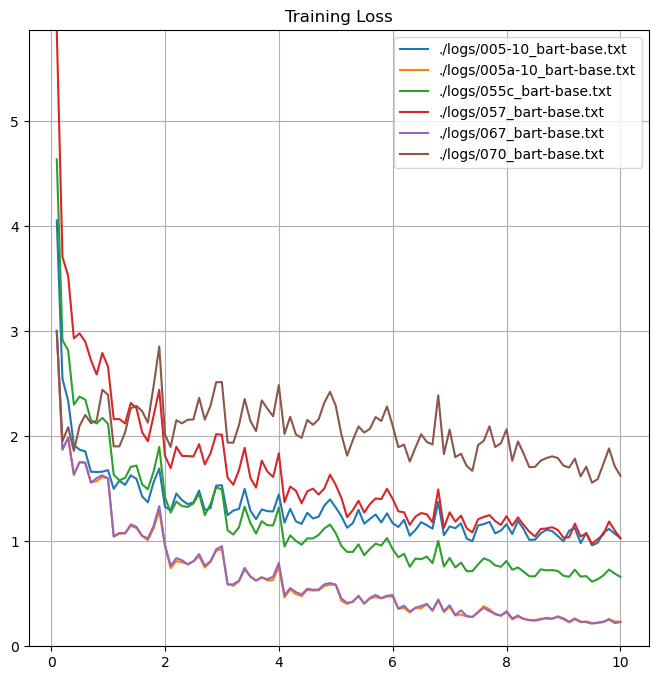

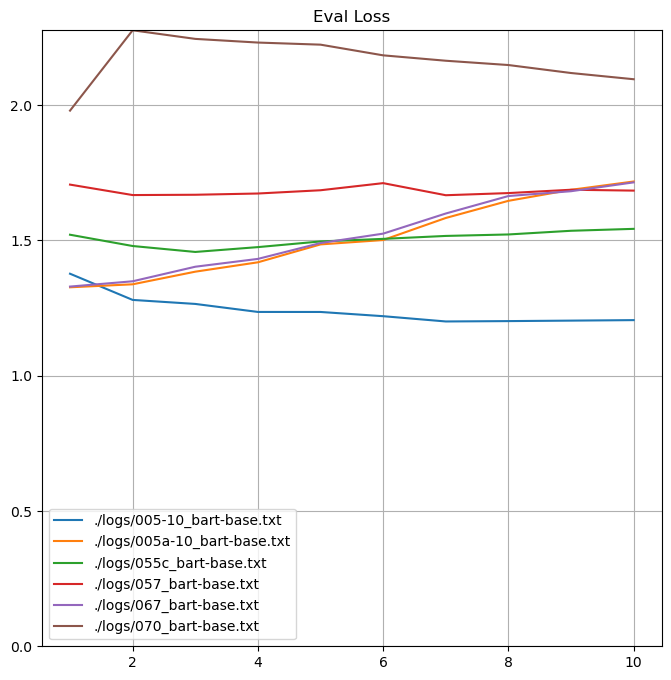

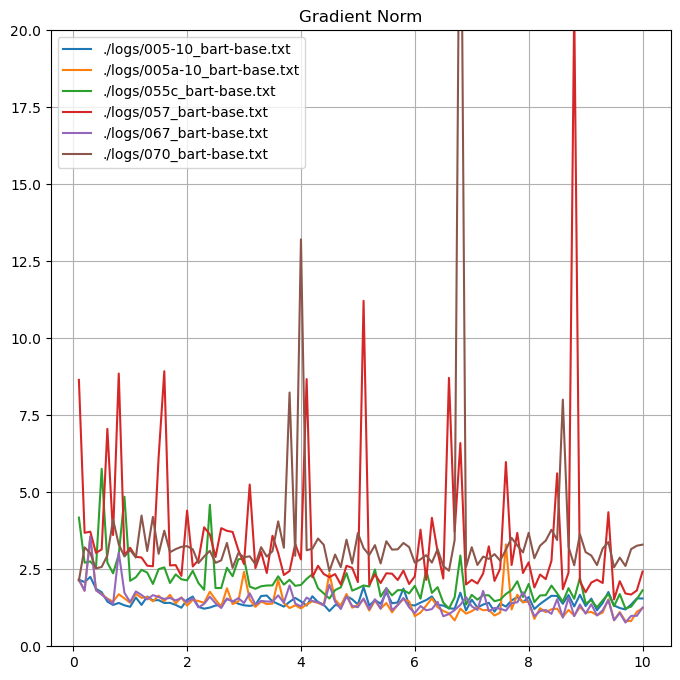

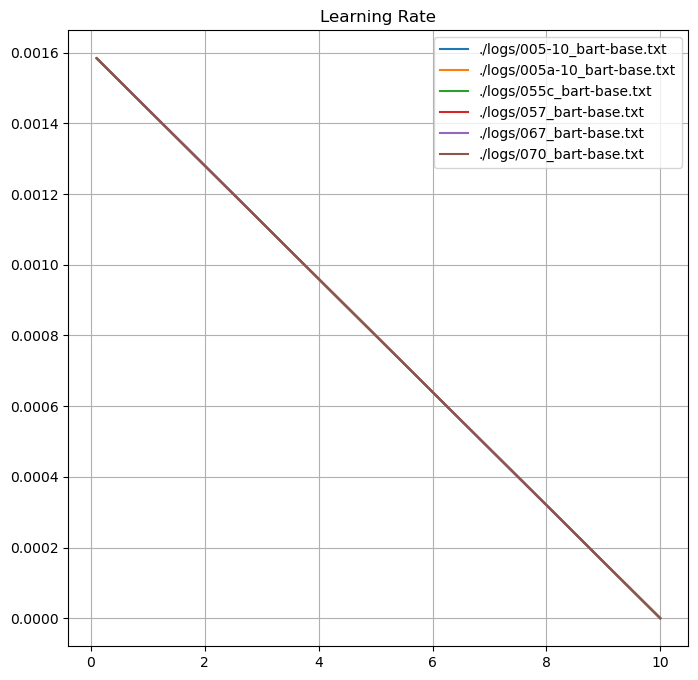

In [165]:
# Regular expression to capture key-value pairs
pattern = re.compile(r"'(\w+)': ([\d.e+-]+)")
fname = './logs/003_bart-base.txt'

fnumbers = list(range(0,4))
fnumbers = [0, 1, 2, 3, 4, 5] # lr experiments
fnumbers = ['5-10', '5a-10']
# fnumbers = [5]

fnames = [f"./logs/00{n}_bart-base.txt" for n in fnumbers]

# fnumbers2 = [14, 15]
# fnumbers2 = [26, 36, 46, 47] # LoRA r, alpha experiments
fnumbers2 = [55, '55a', '55b', '55c', 57] # BART dropout experiments
fnumbers2 = ['55c', 57]
fnumbers2 = fnumbers2 + [67, 70] # weight decay experiments
fnames2 = [f"./logs/0{n}_bart-base.txt" for n in fnumbers2]

fnames = fnames+fnames2

def parse_txt_log(fnames, pattern, plot=True):
    if plot:
        fig_tloss = plt.figure(figsize=(8,8))
        fig_vloss = plt.figure(figsize=(8,8))
        fig_grad_norm = plt.figure(figsize=(8,8))
        fig_lr = plt.figure(figsize=(8,8))

    tlossmax = -1
    vlossmax = -1
    all_results = {fname: {} for fname in fnames}
    for fname in fnames:
        losses = []
        grad_norms = []
        learning_rates = []
        epochs = []

        eval_losses = []
        eval_epochs = []
        
        # Read the file and extract values
        with open(fname, 'r') as file:
            lines = file.readlines()
        
            for line in lines:
                matches = pattern.findall(line)  # Find all key-value pairs in the line
                data = {key: float(value) for key, value in matches}  # Convert to dictionary
        
                # Append the values to the respective lists
                if 'loss' in data:
                    losses.append(data['loss'])
                    
                    if 'grad_norm' in data:
                        grad_norms.append(data['grad_norm'])
                    else:
                        grad_norms.append(0.0)
        
                    if 'learning_rate' in data:
                        learning_rates.append(data['learning_rate'])
                    else:
                        learning_rates.append(0.0)
                    
                    epochs.append(data['epoch'])
                    
                elif 'eval_loss' in data:
                    eval_losses.append(data['eval_loss'])
                    eval_epochs.append(data['epoch'])

            tlossmax = max(tlossmax, max(losses))
            vlossmax = max(vlossmax, max(eval_losses))

        all_results[fname]['tloss'] = losses
        all_results[fname]['grad_norm'] = grad_norms
        all_results[fname]['lr'] = learning_rates
        all_results[fname]['t_epochs'] = epochs
        all_results[fname]['vloss'] = eval_losses
        all_results[fname]['v_epochs'] = eval_epochs

        if plot:
            plt.figure(fig_tloss.number)
            plt.plot(epochs, losses, label=fname)

            plt.figure(fig_vloss.number)
            plt.plot(eval_epochs, eval_losses, label=fname)
    
            plt.figure(fig_grad_norm.number)
            plt.plot(epochs, grad_norms, label=fname)
    
            plt.figure(fig_lr.number)
            plt.plot(epochs, learning_rates, label=fname)

    if plot:
        plt.figure(fig_tloss.number)
        plt.title('Training Loss')
        plt.ylim([0, tlossmax])
        plt.legend()
        plt.grid()

        plt.figure(fig_vloss.number)
        plt.title('Eval Loss')
        plt.ylim([0, vlossmax])
        plt.legend()
        plt.grid()

        plt.figure(fig_grad_norm.number)
        plt.title('Gradient Norm')
        plt.ylim([0, 20])
        plt.legend()
        plt.grid()

        plt.figure(fig_lr.number)
        plt.title('Learning Rate')
        plt.legend()
        plt.grid()

    return all_results
        

all_results = parse_txt_log(fnames, pattern)

In [ ]:
print(len(all_results['./logs/005_bart-base.txt']['t_epochs']))
print(len(all_results['./logs/015_bart-base.txt']['t_epochs']))

# Inference

In [ ]:
# loadmodel = './output/005/'
# model = AutoModelForSeq2SeqLM.from_pretrained(loadmodel)
# tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base', truncation_side='left')

# They didn't use LoRA
tokenizer = AutoTokenizer.from_pretrained("har1/HealthScribe-Clinical_Note_Generator")
model = AutoModelForSeq2SeqLM.from_pretrained("har1/HealthScribe-Clinical_Note_Generator")

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    # train_dataset=ds_train,
    # eval_dataset=ds_eval,
    tokenizer=tokenizer, # only used for generative tasks like translation, summarization, question-answering (to convert decoder predictions/logits back to words) or to work with metrics that require post-processing (BLEU, ROUGE)
    data_collator=data_collator, # dynamic padding
    compute_metrics=valmet.compute_metrics,
)

In [ ]:
ds_test = ds_train.select(range(10))
predictions = trainer.predict(ds_test)
# decoded = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)

In [ ]:
decoder_output_ids = predictions.predictions
decoder_output_ids[decoder_output_ids == -100] = tokenizer.pad_token_id
decoded_output = tokenizer.batch_decode(decoder_output_ids, skip_special_tokens=True)
for odx, out in enumerate(decoded_output):
    print(f'ID: {ds_test[odx]['ID']}')
    print('Dialogue:\n')
    print(ds_test[odx]['dialogue'])
    print('')
    print('Ground truth:\n')
    print(ds_test[odx]['section_text'])
    print('')
    print('Prediction:\n')
    print(out)
    print('')
    print('*******************************************************************')

In [ ]:
predictions.metrics

In [ ]:
del trainer, model

In [ ]:
sample = {}
sample['input_ids'] = ds_train[0]['input_ids'].unsqueeze(dim=0)
sample['attention_mask'] = ds_train[0]['attention_mask'].unsqueeze(dim=0)
sample['labels'] = ds_train[0]['labels'].unsqueeze(dim=0)

In [ ]:
model.to('cpu')
# output = model.generate(**sample, num_beams=4, max_length=150, early_stopping=True)
output = model.generate(**sample, max_new_tokens=200)
decoded = tokenizer.decode(output[0], skip_special_tokens=True)

print('Dialogue:\n')
print(ds_train['dialogue'][0] + '\n')
print('Ground truth:\n')
print(ds_train['section_text'][0] + '\n')
print('Prediction:\n')
print(decoded)

In [ ]:
# Baseline

model_base = AutoModelForSeq2SeqLM.from_pretrained(model_name)
output = model_base.generate(**sample, num_beams=4, max_length=150, early_stopping=True)
decoded_base = tokenizer.decode(output[0], skip_special_tokens=True)

print('Dialogue:\n')
print(ds_train['dialogue'][0] + '\n')
print('Ground truth:\n')
print(ds_train['section_text'][0] + '\n')
print('Prediction:\n')
print(decoded_base)

# Evaluation

In [ ]:
# nli = pipeline("text-classification", model="FacebookAI/roberta-large-mnli")
bertscore = evaluate.load('bertscore')

In [ ]:
r = ds_train['section_text'][0]
p = decoded

In [ ]:
print(f"{r} </s> {p}")
results = nli(f"{r} </s> {p}", truncation=True, top_k=None)
results

In [ ]:
del nli

In [ ]:
results = bertscore.compute(predictions=[p], references=[r], model_type='bert-base-uncased')
results

In [ ]:
p = decoded_base
results = bertscore.compute(predictions=[p], references=[r], model_type='bert-base-uncased')
results

In [ ]:
# del bertscore

# Early Notes
* This is the question you should ask yourself before anything else: what do I want the model to do, and why? Once I figure that out, is there a model out there that already does it? If not, that's when you start thinking about fine-tuning.
* Flexible model: instruction tuning, e.g. "Summarize this into one sentence, summarize this dialogue, etc."
* google/pegasus-xsum and facebook/bart-large-xsum are already pretty good for single-sentence summaries
* facebook/bart-large-cnn and google/pegasus-large - I'm assuming these are pretty good for summaries in general
* You could try to find a dataset that these models don't work well on: https://huggingface.co/datasets/argilla/FinePersonas-Conversations-Email-Summaries?row=18
* Dialog summarization: https://huggingface.co/datasets/knkarthick/dialogsum?row=0
* Question to answer: even the fine-tuned model doesn't summarize the document in one sentence. So what exactly is the objective of my fine-tuning? Remember, I want to change the behavior of my model.
    * **Is it to shorten the summary to one sentence? This might be useful. You could see if you can apply the length objective function.**
    * Is it to summarize in a specific format? Can I find a dataset in that format? Or do I have to spend money to get GPT to do it for me?
    * Is it to get better entailment? For this, I'd need to feed in the original document as the reference, and I don't even know if my entailment model could handle that size.
    * Personally I think bart-large-cnn does a better job of summarization than distilbart-cnn-12-6 (one sample). Is there some way to measure this?
    * I'm not even sure the dataset summary is particularly good (one sample)

# Old Stuff

In [ ]:
print(type(preprocessor.dataloader)) # dictionary. Contains 'train', 'val', 'test'.
print(type(preprocessor.dataloader['train'])) # dataloader


first_batch = next(iter(preprocessor.dataloader['train']))
print(type(first_batch)) # dictionary
print(first_batch.keys())
print(type(first_batch['input_ids']))
print(first_batch['input_ids'].shape)
print(type(first_batch['attention_mask']))
print(first_batch['attention_mask'].shape)
print(type(first_batch['labels']))
print(first_batch['labels'].shape)

In [ ]:
# Example code from https://huggingface.co/docs/datasets/en/use_with_pytorch


import numpy as np
from datasets import Dataset
from torch.utils.data import DataLoader

# Data and labels are scalars, so when you batch with size 4, each batch consists of tensors of length 4
# data = np.random.rand(16)
# label = np.random.randint(0, 2, size=16)


# Modify data and label to be vectors of length 7 (16 total samples)
# Now, when I batch with size 4, each batch consists of 4 tensors (samples) of length 7. So it's working correctly.
data = np.random.rand(16,7)
label = np.random.randint(0, 2, size=(16,7))
ds = Dataset.from_dict({"data": data, "label": label}).with_format("torch")
dataloader = DataLoader(ds, batch_size=4)
for batch in dataloader:
    print(batch)

In [ ]:
label = np.random.randint(0, 2, size=(16,7))
label = np.ones((16,7))

In [ ]:
label.shape

In [ ]:
np.nonzero(label)

In [ ]:
def compute_metrics(eval_pred):
    # Define something here
    return {'my_custom_metric': None}

In [ ]:
training_args = TrainingArguments(
    # Save model checkpoints. # For logging and saving model checkpoints, each 'step' refers to one update of the model's weights.
    # By default, this is once per batch of data, but this isn't necessarily true with gradient accumulation.
    # Typically, we only run validation once per epoch, so there's not much benefit to saving checkpoints more than once per epoch.
    # The only time it's beneficial is if your code is prone to crashing - saving more often means you lose less progress when this happens.
    output_dir='./train_results',
    save_strategy='epoch', # save model checkpoints at the end of each epoch
    eval_strategy='epoch',  # run validation at the end of each epoch

    # Loading the best model state based on the desired metric
    load_best_model_at_end=True,  # load the best model found during training
    # metric_for_best_model="eval_loss",  # Metric to monitor for the best model
    metric_for_best_model='my_custom_metric', # this needs to match a key in the returned dictionary from compute_metrics()
    greater_is_better=True, # higher value for 'my_custom_metric' is better

    # Logs report training and validation metrics, which may be visualized (including in real time) using TensorBoard.
    logging_dir='./train_logs',
    logging_strategy='steps',
    logging_steps=100, # frequency of logging - you need to consider your dataset size and your batch size/gradient accumulation

    per_device_train_batch_size=8, # batch size per device (CPU core/GPU/etc.)
    per_device_eval_batch_size=8, # batch size per device (CPU core/GPU/etc.)

    # Training hyperparameters
    num_train_epochs=10, # max epochs
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # This is the validation dataset
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop after 3 epochs without improvement
    compute_metrics=compute_metrics,  # custom function to compute validation metrics
)

trainer.train()